# Titration Experiment

In [1]:
#############################
#   Experiment parameters   #
#############################
ROOT_DIR = '/analysis/gh-msun/'
PROJECT_SLUG = '2023_06_26_SRT_deconvolution_MS'
EXPERIMENT = 'primary_immune'
TITRATING_CELLTYPE = 'Blueprint-B'
TITRATING_CELLTYPE_ATLAS = 'immune_b' # cell type name in atlas different
BACKGROUND = 'wholeblood' # background: uniform / wholeblood 
N_REPLICATES = 2 # number of replicates for each mixture
SEED = 888 # need to change for different experiment
TOTAL_READS_TO_SAMPLE = 1000000

# make sure the orders of the two list match
CELLTYPES = ['Blueprint-CD4', 'Blueprint-CD8', 'Blueprint-B', 'Blueprint-NK', 'Blueprint-Mono', 'Blueprint-Neutro']
ABRIDGED_NAMES = ['CD4', 'CD8', 'B', 'NK', 'MONO', 'NEUTRO'] # for directory name

# TITRATION_LIST = [0.2, 0.15, 0.10, 0.08, 0.06, 0.04, 0.02, 0.01, 
#                   0.008, 0.006, 0.004, 0.002, 0.001, 0]
TITRATION_LIST=[0.2, 0.15]

# proportion of cells in real whole blood (sum to 1)
WHOLE_BLOOD_ABUNDANCE = {'Blueprint-B':0.06,
                         'Blueprint-Mono':0.09,
                         'Blueprint-Neutro':0.57,
                         'Blueprint-CD4':0.16,
                         'Blueprint-CD8':0.07,
                         'Blueprint-NK':0.05}
    

In [2]:
# Parameters
ROOT_DIR = "/analysis/gh-msun/"
PROJECT_SLUG = "2023_06_26_SRT_deconvolution_MS"
EXPERIMENT = "primary_immune"
TITRATING_CELLTYPE = "Blueprint-CD4"
TITRATING_CELLTYPE_ATLAS = "immune_t"
BACKGROUND = "uniform"
N_REPLICATES = 20
SEED = 83723
TOTAL_READS_TO_SAMPLE = 1000000
CELLTYPES = ["Blueprint-CD4", "Blueprint-CD8", "Blueprint-B", "Blueprint-NK", "Blueprint-Mono", "Blueprint-Neutro"]
ABRIDGED_NAMES = ["CD4", "CD8", "B", "NK", "MONO", "NEUTRO"]
TITRATION_LIST = [0.2, 0.15, 0.1, 0.08, 0.06, 0.04, 0.02, 0.01, 0.008, 0.006, 0.004, 0.002, 0.001, 0]
WHOLE_BLOOD_ABUNDANCE = {"Blueprint-B": 0.06, "Blueprint-Mono": 0.09, "Blueprint-Neutro": 0.57, "Blueprint-CD4": 0.16, "Blueprint-CD8": 0.07, "Blueprint-NK": 0.05}


In [3]:
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
import functools
import os
import regex as re
import random
import importlib
import sys

from pyspark.sql import SparkSession
from pyspark import SparkConf, SparkContext
from pyspark.sql.types import IntegerType, LongType, ArrayType, StringType, DoubleType
from pyspark.sql.functions import udf, explode, broadcast, count, lit, length, col
from pyspark.sql import DataFrame
from pyspark.sql.types import StructType

# UPDATE HOME!
os.environ["SPARK_HOME"] = "/home/ec2-user/mambaforge/envs/2023_06_26_SRT_deconvolution_MS/lib/python3.7/site-packages/pyspark"
# THIS needs to be set-up before running the notebook
os.environ["SPARK_LOCAL_DIRS"] = "/temp"
os.environ["PYARROW_IGNORE_TIMEZONE"] = "1"

spark_conf = SparkConf()
spark_conf.set("spark.ui.showConsoleProgress", "True")
spark_conf.set("spark.executor.instances", "2")
spark_conf.set("spark.executor.cores", "2")
spark_conf.set("spark.executor.memory", "16g")
spark_conf.set("spark.driver.memory", "64g")
spark_conf.set("spark.driver.maxResultSize", "32g")
spark_conf.set("spark.parquet.filterPushdown", "true")
spark_conf.set("spark.local.dir", "/temp")
spark_conf.getAll()

sc = SparkContext(conf=spark_conf)
sc.setLogLevel("ERROR")
spark = SparkSession(sc)

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
sns.set_context('talk')

/home/ec2-user/mambaforge/envs/2023_06_26_SRT_deconvolution_MS/lib/python3.7/site-packages/pyspark/context.py:317: FutureWarning: Python 3.7 support is deprecated in Spark 3.4.
  warnings.warn("Python 3.7 support is deprecated in Spark 3.4.", FutureWarning)


In [4]:
#---Local paths---#
PROJECT_DIR = ROOT_DIR + f'projects/{PROJECT_SLUG}/'

#---Load all custom scripts---#
SCRIPT_DIR = PROJECT_DIR + 'scripts/'
sys.path.append(SCRIPT_DIR)

import create_mixture as cm
import score_matrix as sm
import deconvolution as dcnv
import helper as hlpr

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [5]:
importlib.reload(cm)
importlib.reload(sm)
importlib.reload(dcnv)
importlib.reload(hlpr)

<module 'helper' from '/analysis/gh-msun/projects/2023_06_26_SRT_deconvolution_MS/scripts/helper.py'>

In [6]:
#################################
#   Set titration proportions   #
#################################

# Reorder such that the titrating cell type comes first
CELLTYPES_unordered = CELLTYPES.copy()
CELLTYPES = hlpr.titration_reordering(list_of_cell_types=CELLTYPES, 
                                      titrating_cell_type=TITRATING_CELLTYPE)

# Reorder abridged name
ABRIDGED_NAMES = hlpr.reorder_abridged_name(unordered_celltypes=CELLTYPES_unordered,
                                            ordered_celltypes=CELLTYPES,
                                            unordered_abridged_names=ABRIDGED_NAMES)
    
# set titration proportions
if BACKGROUND == 'uniform':
    PROPORTIONS = hlpr.generate_uniform_background_proportions(titration_list=TITRATION_LIST, 
                                                               cell_types=CELLTYPES)

if BACKGROUND == 'wholeblood':
    PROPORTIONS = hlpr.generate_custom_background_proportions(titration_list=TITRATION_LIST, 
                                                              custom_proportion=WHOLE_BLOOD_ABUNDANCE, 
                                                              list_of_celltypes=CELLTYPES, 
                                                              titrating_celltype=TITRATING_CELLTYPE)

PROPORTIONS[0]    

[0.2, 0.16, 0.16, 0.16, 0.16, 0.16]

## Create mixture

In [7]:
############################
#   Parameters and paths   # 
############################
EXPERIMENT_DIR = PROJECT_DIR + f'output/experiment/{EXPERIMENT}/'
EXPERIMENT_NAME = f'{TITRATING_CELLTYPE}-{BACKGROUND}/'
PARQUET_PATH = PROJECT_DIR + 'output/mixture_source/'
EXPERIMENT_CELLTYPE_DIR = EXPERIMENT_DIR + f'{EXPERIMENT_NAME}/'
RESULT_PATH = EXPERIMENT_CELLTYPE_DIR + 'mixture/'


In [8]:
%%time
# load parquet files for each celltype & count rows
parquet_df, total_reads_per_celltype = cm.load_parquet_dataframe(parquet_path=PARQUET_PATH,
                                                                  cell_types=CELLTYPES,
                                                                  spark=spark,
                                                                  verbose=True)

# mix cell types for each proportion set
cm.mix_celltypes_multiple_proportions(parquet_df=parquet_df,
                                       total_reads_per_celltype=total_reads_per_celltype,
                                    #    n=len(TITRATION_LIST), 
                                       n=N_REPLICATES,
                                       cell_types=CELLTYPES, 
                                       cell_type_abridged_name=ABRIDGED_NAMES, 
                                       total_reads_to_sample=TOTAL_READS_TO_SAMPLE, 
                                       list_of_proportions=PROPORTIONS, 
                                       seed=SEED, 
                                       result_path=RESULT_PATH, 
                                       spark=spark,
                                       verbose=False, 
                                       save=True)

>>> Load parquet files and count rows... <<<
----------> Loading cell type: Blueprint-CD4


----------> Loading cell type: Blueprint-CD8


----------> Loading cell type: Blueprint-B


----------> Loading cell type: Blueprint-NK


----------> Loading cell type: Blueprint-Mono


----------> Loading cell type: Blueprint-Neutro


>>> Complete. <<< 

>>> Start mixing... <<<
--> PROPORTION: [0.2, 0.16, 0.16, 0.16, 0.16, 0.16]
----------> Creating mixture 0... 


----------> Creating mixture 1... 


----------> Creating mixture 2... 


----------> Creating mixture 3... 


----------> Creating mixture 4... 


----------> Creating mixture 5... 


----------> Creating mixture 6... 


----------> Creating mixture 7... 


----------> Creating mixture 8... 


----------> Creating mixture 9... 


----------> Creating mixture 10... 


----------> Creating mixture 11... 


----------> Creating mixture 12... 


----------> Creating mixture 13... 


----------> Creating mixture 14... 


----------> Creating mixture 15... 


----------> Creating mixture 16... 


----------> Creating mixture 17... 


----------> Creating mixture 18... 


----------> Creating mixture 19... 


--> PROPORTION: [0.15, 0.16999999999999998, 0.16999999999999998, 0.16999999999999998, 0.16999999999999998, 0.16999999999999998]
----------> Creating mixture 0... 


----------> Creating mixture 1... 


----------> Creating mixture 2... 


----------> Creating mixture 3... 


----------> Creating mixture 4... 


----------> Creating mixture 5... 


----------> Creating mixture 6... 


----------> Creating mixture 7... 


----------> Creating mixture 8... 


----------> Creating mixture 9... 


----------> Creating mixture 10... 


----------> Creating mixture 11... 


----------> Creating mixture 12... 


----------> Creating mixture 13... 


----------> Creating mixture 14... 


----------> Creating mixture 15... 


----------> Creating mixture 16... 


----------> Creating mixture 17... 


----------> Creating mixture 18... 


----------> Creating mixture 19... 


--> PROPORTION: [0.1, 0.18, 0.18, 0.18, 0.18, 0.18]
----------> Creating mixture 0... 


----------> Creating mixture 1... 


----------> Creating mixture 2... 


----------> Creating mixture 3... 


----------> Creating mixture 4... 


----------> Creating mixture 5... 


----------> Creating mixture 6... 


----------> Creating mixture 7... 


----------> Creating mixture 8... 


----------> Creating mixture 9... 


----------> Creating mixture 10... 


----------> Creating mixture 11... 


----------> Creating mixture 12... 


----------> Creating mixture 13... 


----------> Creating mixture 14... 


----------> Creating mixture 15... 


----------> Creating mixture 16... 


----------> Creating mixture 17... 


----------> Creating mixture 18... 


----------> Creating mixture 19... 


--> PROPORTION: [0.08, 0.184, 0.184, 0.184, 0.184, 0.184]
----------> Creating mixture 0... 


----------> Creating mixture 1... 


----------> Creating mixture 2... 


----------> Creating mixture 3... 


----------> Creating mixture 4... 


----------> Creating mixture 5... 


----------> Creating mixture 6... 


----------> Creating mixture 7... 


----------> Creating mixture 8... 


----------> Creating mixture 9... 


----------> Creating mixture 10... 


----------> Creating mixture 11... 


----------> Creating mixture 12... 


----------> Creating mixture 13... 


----------> Creating mixture 14... 


----------> Creating mixture 15... 


----------> Creating mixture 16... 


----------> Creating mixture 17... 


----------> Creating mixture 18... 


----------> Creating mixture 19... 


--> PROPORTION: [0.06, 0.188, 0.188, 0.188, 0.188, 0.188]
----------> Creating mixture 0... 


----------> Creating mixture 1... 


----------> Creating mixture 2... 


----------> Creating mixture 3... 


----------> Creating mixture 4... 


----------> Creating mixture 5... 


----------> Creating mixture 6... 


----------> Creating mixture 7... 


----------> Creating mixture 8... 


----------> Creating mixture 9... 


----------> Creating mixture 10... 


----------> Creating mixture 11... 


----------> Creating mixture 12... 


----------> Creating mixture 13... 


----------> Creating mixture 14... 


----------> Creating mixture 15... 


----------> Creating mixture 16... 


----------> Creating mixture 17... 


----------> Creating mixture 18... 


----------> Creating mixture 19... 


--> PROPORTION: [0.04, 0.192, 0.192, 0.192, 0.192, 0.192]
----------> Creating mixture 0... 


----------> Creating mixture 1... 


----------> Creating mixture 2... 


----------> Creating mixture 3... 


----------> Creating mixture 4... 


----------> Creating mixture 5... 


----------> Creating mixture 6... 


----------> Creating mixture 7... 


----------> Creating mixture 8... 


----------> Creating mixture 9... 


----------> Creating mixture 10... 


----------> Creating mixture 11... 


----------> Creating mixture 12... 


----------> Creating mixture 13... 


----------> Creating mixture 14... 


----------> Creating mixture 15... 


----------> Creating mixture 16... 


----------> Creating mixture 17... 


----------> Creating mixture 18... 


----------> Creating mixture 19... 


--> PROPORTION: [0.02, 0.196, 0.196, 0.196, 0.196, 0.196]
----------> Creating mixture 0... 


----------> Creating mixture 1... 


----------> Creating mixture 2... 


----------> Creating mixture 3... 


----------> Creating mixture 4... 


----------> Creating mixture 5... 


----------> Creating mixture 6... 


----------> Creating mixture 7... 


----------> Creating mixture 8... 


----------> Creating mixture 9... 


----------> Creating mixture 10... 


----------> Creating mixture 11... 


----------> Creating mixture 12... 


----------> Creating mixture 13... 


----------> Creating mixture 14... 


----------> Creating mixture 15... 


----------> Creating mixture 16... 


----------> Creating mixture 17... 


----------> Creating mixture 18... 


----------> Creating mixture 19... 


--> PROPORTION: [0.01, 0.198, 0.198, 0.198, 0.198, 0.198]
----------> Creating mixture 0... 


----------> Creating mixture 1... 


----------> Creating mixture 2... 


----------> Creating mixture 3... 


----------> Creating mixture 4... 


----------> Creating mixture 5... 


----------> Creating mixture 6... 


----------> Creating mixture 7... 


----------> Creating mixture 8... 


----------> Creating mixture 9... 


----------> Creating mixture 10... 


----------> Creating mixture 11... 


----------> Creating mixture 12... 


----------> Creating mixture 13... 


----------> Creating mixture 14... 


----------> Creating mixture 15... 


----------> Creating mixture 16... 


----------> Creating mixture 17... 


----------> Creating mixture 18... 


----------> Creating mixture 19... 


--> PROPORTION: [0.008, 0.1984, 0.1984, 0.1984, 0.1984, 0.1984]
----------> Creating mixture 0... 


----------> Creating mixture 1... 


----------> Creating mixture 2... 


----------> Creating mixture 3... 


----------> Creating mixture 4... 


----------> Creating mixture 5... 


----------> Creating mixture 6... 


----------> Creating mixture 7... 


----------> Creating mixture 8... 


----------> Creating mixture 9... 


----------> Creating mixture 10... 


----------> Creating mixture 11... 


----------> Creating mixture 12... 


----------> Creating mixture 13... 


----------> Creating mixture 14... 


----------> Creating mixture 15... 


----------> Creating mixture 16... 


----------> Creating mixture 17... 


----------> Creating mixture 18... 


----------> Creating mixture 19... 


--> PROPORTION: [0.006, 0.1988, 0.1988, 0.1988, 0.1988, 0.1988]
----------> Creating mixture 0... 


----------> Creating mixture 1... 


----------> Creating mixture 2... 


----------> Creating mixture 3... 


----------> Creating mixture 4... 


----------> Creating mixture 5... 


----------> Creating mixture 6... 


----------> Creating mixture 7... 


----------> Creating mixture 8... 


----------> Creating mixture 9... 


----------> Creating mixture 10... 


----------> Creating mixture 11... 


----------> Creating mixture 12... 


----------> Creating mixture 13... 


----------> Creating mixture 14... 


----------> Creating mixture 15... 


----------> Creating mixture 16... 


----------> Creating mixture 17... 


----------> Creating mixture 18... 


----------> Creating mixture 19... 


--> PROPORTION: [0.004, 0.1992, 0.1992, 0.1992, 0.1992, 0.1992]
----------> Creating mixture 0... 


----------> Creating mixture 1... 


----------> Creating mixture 2... 


----------> Creating mixture 3... 


----------> Creating mixture 4... 


----------> Creating mixture 5... 


----------> Creating mixture 6... 


----------> Creating mixture 7... 


----------> Creating mixture 8... 


----------> Creating mixture 9... 


----------> Creating mixture 10... 


----------> Creating mixture 11... 


----------> Creating mixture 12... 


----------> Creating mixture 13... 


----------> Creating mixture 14... 


----------> Creating mixture 15... 


----------> Creating mixture 16... 


----------> Creating mixture 17... 


----------> Creating mixture 18... 


----------> Creating mixture 19... 


--> PROPORTION: [0.002, 0.1996, 0.1996, 0.1996, 0.1996, 0.1996]
----------> Creating mixture 0... 


----------> Creating mixture 1... 


----------> Creating mixture 2... 


----------> Creating mixture 3... 


----------> Creating mixture 4... 


----------> Creating mixture 5... 


----------> Creating mixture 6... 


----------> Creating mixture 7... 


----------> Creating mixture 8... 


----------> Creating mixture 9... 


----------> Creating mixture 10... 


----------> Creating mixture 11... 


----------> Creating mixture 12... 


----------> Creating mixture 13... 


----------> Creating mixture 14... 


----------> Creating mixture 15... 


----------> Creating mixture 16... 


----------> Creating mixture 17... 


----------> Creating mixture 18... 


----------> Creating mixture 19... 


--> PROPORTION: [0.001, 0.1998, 0.1998, 0.1998, 0.1998, 0.1998]
----------> Creating mixture 0... 


----------> Creating mixture 1... 


----------> Creating mixture 2... 


----------> Creating mixture 3... 


----------> Creating mixture 4... 


----------> Creating mixture 5... 


----------> Creating mixture 6... 


----------> Creating mixture 7... 


----------> Creating mixture 8... 


----------> Creating mixture 9... 


----------> Creating mixture 10... 


----------> Creating mixture 11... 


----------> Creating mixture 12... 


----------> Creating mixture 13... 


----------> Creating mixture 14... 


----------> Creating mixture 15... 


----------> Creating mixture 16... 


----------> Creating mixture 17... 


----------> Creating mixture 18... 


----------> Creating mixture 19... 


--> PROPORTION: [0, 0.2, 0.2, 0.2, 0.2, 0.2]
----------> Creating mixture 0... 


----------> Creating mixture 1... 


----------> Creating mixture 2... 


----------> Creating mixture 3... 


----------> Creating mixture 4... 


----------> Creating mixture 5... 


----------> Creating mixture 6... 


----------> Creating mixture 7... 


----------> Creating mixture 8... 


----------> Creating mixture 9... 


----------> Creating mixture 10... 


----------> Creating mixture 11... 


----------> Creating mixture 12... 


----------> Creating mixture 13... 


----------> Creating mixture 14... 


----------> Creating mixture 15... 


----------> Creating mixture 16... 


----------> Creating mixture 17... 


----------> Creating mixture 18... 


----------> Creating mixture 19... 


>>> Complete. <<< 

CPU times: user 1.41 s, sys: 353 ms, total: 1.77 s
Wall time: 23min 45s


## Compute score matrix

In [9]:
############################
#   Parameters and paths   # 
############################

FILTER_CG_COUNT = 3
FILTER_CG_COUNT_REGION = 1

REGIONS = 'deconvolution_v2.v23_conv.with_cpg_index'
REGION_BED_COLS = [
    'region_chr', 'region_start', 'region_end', 
    'region_cpg_index_min', 'region_cpg_index_max', 'region_id'
]

# Regions
REGION_PATH = (
    PROJECT_DIR + '/stage/panel_data/{regions}.bed'
).format(regions=REGIONS)

# CpG map; genomic coordinate to CpG index;
CPG_MAP_PATH = PROJECT_DIR + '/stage/cpg_loci/cpg_loci_hg19.combined_annot.tsv.gz'

#--- Where to store results
PATH_TO_MIXTURE_DIR = EXPERIMENT_CELLTYPE_DIR + 'mixture/'
RESULT_PATH = EXPERIMENT_CELLTYPE_DIR


In [10]:
cpg_map = pd.read_csv(CPG_MAP_PATH, usecols=['chr', 'start', 'end', 'cpg_index', 'cpg_index_hg38'], sep='\t')

In [11]:
%%time
ridxs = ~cpg_map['cpg_index_hg38'].isna()
hg19_hg38_map = dict(itertools.zip_longest(cpg_map[ridxs]['cpg_index'], cpg_map[ridxs]['cpg_index_hg38'].astype(int)))
hg38_hg19_map = dict(itertools.zip_longest(cpg_map[ridxs]['cpg_index_hg38'].astype(int), cpg_map[ridxs]['cpg_index']))

CPU times: user 14.9 s, sys: 7.03 s, total: 21.9 s
Wall time: 21.9 s


In [12]:
region_df = pd.read_csv(REGION_PATH, sep='\t', usecols=range(0, 6), names=REGION_BED_COLS)

region_df['region_cpg_index_max'] -= 1
region_df.sort_values('region_cpg_index_min', inplace=True)
region_df['region_cpg_index_min_hg38'] = region_df['region_cpg_index_min'].map(hg19_hg38_map)
region_df['region_cpg_index_max_hg38'] = region_df['region_cpg_index_max'].map(hg19_hg38_map)

region_df.shape[0], region_df['region_id'].nunique()

(1658, 1658)

In [13]:
ridxs = ~region_df['region_cpg_index_min_hg38'].isna()
ridxs &= ~region_df['region_cpg_index_max_hg38'].isna()
region_df = region_df[ridxs].copy()
region_df.shape[0], region_df['region_id'].nunique()

(1658, 1658)

In [14]:
cg_count_hg19 = region_df['region_cpg_index_max']-region_df['region_cpg_index_min'] + 1
cg_count_hg38 = region_df['region_cpg_index_max_hg38']-region_df['region_cpg_index_min_hg38'] + 1
ridxs = (cg_count_hg19==cg_count_hg38)
ridxs &= (cg_count_hg19>=FILTER_CG_COUNT_REGION)
region_df = region_df[ridxs].copy()
region_df.shape[0], region_df['region_id'].nunique()

(1657, 1657)

In [15]:
region_df['region_cpg_index_min_hg38'] = region_df['region_cpg_index_min_hg38'].astype(int)
region_df['region_cpg_index_max_hg38'] = region_df['region_cpg_index_max_hg38'].astype(int)

In [16]:
### Restrict to immune regions
#-------------- CHANGE HERE FOR DIFFERENT REGION SUBSET ----------------------
# BLUEPRINT immune regions
ATLAS_PATH = PROJECT_DIR + f'/output/reference/deconv_inhouse_v2.atlas.tsv.gz'
atlas = pd.read_csv(ATLAS_PATH, sep='\t')
subset_region_set = set(atlas.region_id)
#-----------------------------------------------------------------------------

# filter regions down to regions of interest
region_df = region_df[region_df['region_id'].isin(subset_region_set)]
region_df.head()

,region_chr,region_start,region_end,region_cpg_index_min,region_cpg_index_max,region_id,region_cpg_index_min_hg38,region_cpg_index_max_hg38
0,chr1,1114771,1114971,20117,20129,Immune_Broad_B-chr1:1114772-1114971,21119,21131
1,chr1,1157450,1157720,21684,21703,Immune_Broad_NK-chr1:1157451-1157720,22686,22705
2,chr1,1157879,1158277,21710,21726,Immune_Broad_NK-chr1:1157880-1158277,22712,22728
14,chr1,6341182,6341377,140667,140681,Immune_Broad_Eosi-chr1:6341183-6341377,142368,142382
19,chr1,9147788,9147871,188605,188608,Immune_Broad_Neutro-chr1:9147789-9147871,190307,190310


In [17]:
%%time

PAT_COLS = [
    'molecule_id', 'chr', 'number_molecules',
    'cpg_index_min', 'cpg_index_max', 'pat_string', 'region_id', 'region_cpg_index_min', 'region_cpg_index_max'
]

QUANTILES = [0.1, 0.25, 0.75, 0.9]
KMERS = [1, 3, 4]
RATES_LEQ = [0.25]
RATES_GEQ = [0.75]

RETURN_SCHEMA = StructType()\
    .add('region_id', 'string')\
    .add('number_molecules', 'integer')\
    .add('meth_k1', 'integer')\
    .add('unmeth_k1', 'integer')\
    .add('total_k1', 'integer')\
    .add('meth_k3', 'integer')\
    .add('unmeth_k3', 'integer')\
    .add('total_k3', 'integer')\
    .add('meth_k4', 'integer')\
    .add('unmeth_k4', 'integer')\
    .add('total_k4', 'integer')\
    .add('frac_alpha_leq_25pct', 'float')\
    .add('frac_alpha_geq_75pct', 'float')

compute_frag_scores_udf = sm.compute_frag_scores(cpg_number_cutoff=FILTER_CG_COUNT, schema=RETURN_SCHEMA, kmers=KMERS, rates_leq=RATES_LEQ, rates_geq=RATES_GEQ)


# compute methyl score for are parquet files
sm.score_matrix_from_mixture_directory(path_to_mixture_dir = PATH_TO_MIXTURE_DIR, 
                                       result_path = RESULT_PATH, 
                                       pat_cols = PAT_COLS, 
                                       region_df = region_df, 
                                       batch_size = 20, 
                                       schema = RETURN_SCHEMA, 
                                       spark=spark,
                                       compute_frag_scores_udf=compute_frag_scores_udf,
                                       save=True, 
                                       verbose=False)

>>> Start computing score matrices <<< 

--> E2CD4_E16CD8_E16B_E16NK_E16MONO_E16NEUTRO
--------> Computing score matrix for mix0_seed470800


--------> Computing score matrix for mix1_seed966852


--------> Computing score matrix for mix2_seed995826


--------> Computing score matrix for mix3_seed796153


--------> Computing score matrix for mix4_seed344757


--------> Computing score matrix for mix5_seed911735


--------> Computing score matrix for mix6_seed760126


--------> Computing score matrix for mix7_seed746477


--------> Computing score matrix for mix8_seed823635


--------> Computing score matrix for mix9_seed913498


--------> Computing score matrix for mix10_seed904203


--------> Computing score matrix for mix11_seed52304


--------> Computing score matrix for mix12_seed837207


--------> Computing score matrix for mix13_seed762180


--------> Computing score matrix for mix14_seed4427


--------> Computing score matrix for mix15_seed816021


--------> Computing score matrix for mix16_seed859354


--------> Computing score matrix for mix17_seed263244


--------> Computing score matrix for mix18_seed965215


--------> Computing score matrix for mix19_seed454336




--> E15CD4_E17CD8_E17B_E17NK_E17MONO_E17NEUTRO
--------> Computing score matrix for mix0_seed327469


--------> Computing score matrix for mix1_seed942713


--------> Computing score matrix for mix2_seed899730


--------> Computing score matrix for mix3_seed115834


--------> Computing score matrix for mix4_seed885610


--------> Computing score matrix for mix5_seed381195


--------> Computing score matrix for mix6_seed573121


--------> Computing score matrix for mix7_seed340732


--------> Computing score matrix for mix8_seed323110


--------> Computing score matrix for mix9_seed40411


--------> Computing score matrix for mix10_seed290884


--------> Computing score matrix for mix11_seed54615


--------> Computing score matrix for mix12_seed229926


--------> Computing score matrix for mix13_seed414827


--------> Computing score matrix for mix14_seed424406


--------> Computing score matrix for mix15_seed392389


--------> Computing score matrix for mix16_seed757798


--------> Computing score matrix for mix17_seed600928


--------> Computing score matrix for mix18_seed44327


--------> Computing score matrix for mix19_seed42805




--> E1CD4_E18CD8_E18B_E18NK_E18MONO_E18NEUTRO
--------> Computing score matrix for mix0_seed997493


--------> Computing score matrix for mix1_seed479596


--------> Computing score matrix for mix2_seed228823


--------> Computing score matrix for mix3_seed971831


--------> Computing score matrix for mix4_seed289341


--------> Computing score matrix for mix5_seed142973


--------> Computing score matrix for mix6_seed823233


--------> Computing score matrix for mix7_seed365790


--------> Computing score matrix for mix8_seed816729


--------> Computing score matrix for mix9_seed203631


--------> Computing score matrix for mix10_seed36380


--------> Computing score matrix for mix11_seed783406


--------> Computing score matrix for mix12_seed994708


--------> Computing score matrix for mix13_seed60323


--------> Computing score matrix for mix14_seed241588


--------> Computing score matrix for mix15_seed303026


--------> Computing score matrix for mix16_seed696098


--------> Computing score matrix for mix17_seed358335


--------> Computing score matrix for mix18_seed573110


--------> Computing score matrix for mix19_seed388752




--> E08CD4_E184CD8_E184B_E184NK_E184MONO_E184NEUTRO
--------> Computing score matrix for mix0_seed179747


--------> Computing score matrix for mix1_seed539546


--------> Computing score matrix for mix2_seed950413


--------> Computing score matrix for mix3_seed202997


--------> Computing score matrix for mix4_seed411889


--------> Computing score matrix for mix5_seed607876


--------> Computing score matrix for mix6_seed330186


--------> Computing score matrix for mix7_seed222930


--------> Computing score matrix for mix8_seed628990


--------> Computing score matrix for mix9_seed519025


--------> Computing score matrix for mix10_seed776683


--------> Computing score matrix for mix11_seed710508


--------> Computing score matrix for mix12_seed897517


--------> Computing score matrix for mix13_seed949716


--------> Computing score matrix for mix14_seed515738


--------> Computing score matrix for mix15_seed759815


--------> Computing score matrix for mix16_seed965445


--------> Computing score matrix for mix17_seed295822


--------> Computing score matrix for mix18_seed225164


--------> Computing score matrix for mix19_seed232894




--> E06CD4_E188CD8_E188B_E188NK_E188MONO_E188NEUTRO
--------> Computing score matrix for mix0_seed394807


--------> Computing score matrix for mix1_seed91698


--------> Computing score matrix for mix2_seed259385


--------> Computing score matrix for mix3_seed512999


--------> Computing score matrix for mix4_seed129635


--------> Computing score matrix for mix5_seed350607


--------> Computing score matrix for mix6_seed684378


--------> Computing score matrix for mix7_seed8190


--------> Computing score matrix for mix8_seed779725


--------> Computing score matrix for mix9_seed415085


--------> Computing score matrix for mix10_seed444818


--------> Computing score matrix for mix11_seed199195


--------> Computing score matrix for mix12_seed918219


--------> Computing score matrix for mix13_seed510736


--------> Computing score matrix for mix14_seed500261


--------> Computing score matrix for mix15_seed956732


--------> Computing score matrix for mix16_seed921572


--------> Computing score matrix for mix17_seed937247


--------> Computing score matrix for mix18_seed110110


--------> Computing score matrix for mix19_seed564768




--> E04CD4_E192CD8_E192B_E192NK_E192MONO_E192NEUTRO
--------> Computing score matrix for mix0_seed778556


--------> Computing score matrix for mix1_seed119019


--------> Computing score matrix for mix2_seed810366


--------> Computing score matrix for mix3_seed869675


--------> Computing score matrix for mix4_seed408609


--------> Computing score matrix for mix5_seed759534


--------> Computing score matrix for mix6_seed139682


--------> Computing score matrix for mix7_seed362934


--------> Computing score matrix for mix8_seed349169


--------> Computing score matrix for mix9_seed357510


--------> Computing score matrix for mix10_seed67133


--------> Computing score matrix for mix11_seed500109


--------> Computing score matrix for mix12_seed837330


--------> Computing score matrix for mix13_seed972082


--------> Computing score matrix for mix14_seed636923


--------> Computing score matrix for mix15_seed873445


--------> Computing score matrix for mix16_seed313816


--------> Computing score matrix for mix17_seed608328


--------> Computing score matrix for mix18_seed58802


--------> Computing score matrix for mix19_seed782912




--> E02CD4_E196CD8_E196B_E196NK_E196MONO_E196NEUTRO
--------> Computing score matrix for mix0_seed933600


--------> Computing score matrix for mix1_seed428927


--------> Computing score matrix for mix2_seed814759


--------> Computing score matrix for mix3_seed819227


--------> Computing score matrix for mix4_seed270332


--------> Computing score matrix for mix5_seed222732


--------> Computing score matrix for mix6_seed306825


--------> Computing score matrix for mix7_seed950787


--------> Computing score matrix for mix8_seed496575


--------> Computing score matrix for mix9_seed590288


--------> Computing score matrix for mix10_seed827096


--------> Computing score matrix for mix11_seed896360


--------> Computing score matrix for mix12_seed358536


--------> Computing score matrix for mix13_seed709589


--------> Computing score matrix for mix14_seed441282


--------> Computing score matrix for mix15_seed166028


--------> Computing score matrix for mix16_seed418991


--------> Computing score matrix for mix17_seed669616


--------> Computing score matrix for mix18_seed237520


--------> Computing score matrix for mix19_seed351999




--> E01CD4_E198CD8_E198B_E198NK_E198MONO_E198NEUTRO
--------> Computing score matrix for mix0_seed132847


--------> Computing score matrix for mix1_seed126869


--------> Computing score matrix for mix2_seed504808


--------> Computing score matrix for mix3_seed62714


--------> Computing score matrix for mix4_seed709570


--------> Computing score matrix for mix5_seed648025


--------> Computing score matrix for mix6_seed57003


--------> Computing score matrix for mix7_seed922333


--------> Computing score matrix for mix8_seed732575


--------> Computing score matrix for mix9_seed604723


--------> Computing score matrix for mix10_seed886210


--------> Computing score matrix for mix11_seed288402


--------> Computing score matrix for mix12_seed226581


--------> Computing score matrix for mix13_seed203188


--------> Computing score matrix for mix14_seed253052


--------> Computing score matrix for mix15_seed8805


--------> Computing score matrix for mix16_seed585491


--------> Computing score matrix for mix17_seed754192


--------> Computing score matrix for mix18_seed43717


--------> Computing score matrix for mix19_seed946289




--> E008CD4_E1984CD8_E1984B_E1984NK_E1984MONO_E1984NEUTRO
--------> Computing score matrix for mix0_seed730472


--------> Computing score matrix for mix1_seed799085


--------> Computing score matrix for mix2_seed824908


--------> Computing score matrix for mix3_seed35356


--------> Computing score matrix for mix4_seed446376


--------> Computing score matrix for mix5_seed855752


--------> Computing score matrix for mix6_seed977176


--------> Computing score matrix for mix7_seed957129


--------> Computing score matrix for mix8_seed870459


--------> Computing score matrix for mix9_seed169567


--------> Computing score matrix for mix10_seed349005


--------> Computing score matrix for mix11_seed345138


--------> Computing score matrix for mix12_seed18159


--------> Computing score matrix for mix13_seed649160


--------> Computing score matrix for mix14_seed397897


--------> Computing score matrix for mix15_seed51768


--------> Computing score matrix for mix16_seed652330


--------> Computing score matrix for mix17_seed309227


--------> Computing score matrix for mix18_seed866176


--------> Computing score matrix for mix19_seed62078




--> E006CD4_E1988CD8_E1988B_E1988NK_E1988MONO_E1988NEUTRO
--------> Computing score matrix for mix0_seed79780


--------> Computing score matrix for mix1_seed464872


--------> Computing score matrix for mix2_seed620943


--------> Computing score matrix for mix3_seed100571


--------> Computing score matrix for mix4_seed561928


--------> Computing score matrix for mix5_seed475921


--------> Computing score matrix for mix6_seed472947


--------> Computing score matrix for mix7_seed165049


--------> Computing score matrix for mix8_seed180339


--------> Computing score matrix for mix9_seed980836


--------> Computing score matrix for mix10_seed279683


--------> Computing score matrix for mix11_seed270246


--------> Computing score matrix for mix12_seed915111


--------> Computing score matrix for mix13_seed125829


--------> Computing score matrix for mix14_seed898630


--------> Computing score matrix for mix15_seed998298


--------> Computing score matrix for mix16_seed980322


--------> Computing score matrix for mix17_seed844121


--------> Computing score matrix for mix18_seed47421


--------> Computing score matrix for mix19_seed532266




--> E004CD4_E1992CD8_E1992B_E1992NK_E1992MONO_E1992NEUTRO
--------> Computing score matrix for mix0_seed641231


--------> Computing score matrix for mix1_seed747508


--------> Computing score matrix for mix2_seed118499


--------> Computing score matrix for mix3_seed88247


--------> Computing score matrix for mix4_seed623111


--------> Computing score matrix for mix5_seed534084


--------> Computing score matrix for mix6_seed536255


--------> Computing score matrix for mix7_seed20968


--------> Computing score matrix for mix8_seed506323


--------> Computing score matrix for mix9_seed965956


--------> Computing score matrix for mix10_seed174811


--------> Computing score matrix for mix11_seed680928


--------> Computing score matrix for mix12_seed346965


--------> Computing score matrix for mix13_seed293045


--------> Computing score matrix for mix14_seed694779


--------> Computing score matrix for mix15_seed875846


--------> Computing score matrix for mix16_seed250263


--------> Computing score matrix for mix17_seed75184


--------> Computing score matrix for mix18_seed555744


--------> Computing score matrix for mix19_seed662373




--> E002CD4_E1996CD8_E1996B_E1996NK_E1996MONO_E1996NEUTRO
--------> Computing score matrix for mix0_seed170425


--------> Computing score matrix for mix1_seed287214


--------> Computing score matrix for mix2_seed127448


--------> Computing score matrix for mix3_seed519752


--------> Computing score matrix for mix4_seed891717


--------> Computing score matrix for mix5_seed809809


--------> Computing score matrix for mix6_seed654894


--------> Computing score matrix for mix7_seed934408


--------> Computing score matrix for mix8_seed690064


--------> Computing score matrix for mix9_seed545577


--------> Computing score matrix for mix10_seed591570


--------> Computing score matrix for mix11_seed186616


--------> Computing score matrix for mix12_seed840210


--------> Computing score matrix for mix13_seed948059


--------> Computing score matrix for mix14_seed139203


--------> Computing score matrix for mix15_seed634896


--------> Computing score matrix for mix16_seed239642


--------> Computing score matrix for mix17_seed88850


--------> Computing score matrix for mix18_seed93528


--------> Computing score matrix for mix19_seed16509




--> E001CD4_E1998CD8_E1998B_E1998NK_E1998MONO_E1998NEUTRO
--------> Computing score matrix for mix0_seed284428


--------> Computing score matrix for mix1_seed984362


--------> Computing score matrix for mix2_seed99641


--------> Computing score matrix for mix3_seed33648


--------> Computing score matrix for mix4_seed88744


--------> Computing score matrix for mix5_seed58786


--------> Computing score matrix for mix6_seed314156


--------> Computing score matrix for mix7_seed398555


--------> Computing score matrix for mix8_seed356510


--------> Computing score matrix for mix9_seed779564


--------> Computing score matrix for mix10_seed618092


--------> Computing score matrix for mix11_seed853391


--------> Computing score matrix for mix12_seed699373


--------> Computing score matrix for mix13_seed294117


--------> Computing score matrix for mix14_seed930971


--------> Computing score matrix for mix15_seed641038


--------> Computing score matrix for mix16_seed802607


--------> Computing score matrix for mix17_seed180881


--------> Computing score matrix for mix18_seed655677


--------> Computing score matrix for mix19_seed596630




--> ECD4_E2CD8_E2B_E2NK_E2MONO_E2NEUTRO
--------> Computing score matrix for mix0_seed710180


--------> Computing score matrix for mix1_seed278790


--------> Computing score matrix for mix2_seed918832


--------> Computing score matrix for mix3_seed537476


--------> Computing score matrix for mix4_seed536639


--------> Computing score matrix for mix5_seed336297


--------> Computing score matrix for mix6_seed56359


--------> Computing score matrix for mix7_seed572026


--------> Computing score matrix for mix8_seed619391


--------> Computing score matrix for mix9_seed632208


--------> Computing score matrix for mix10_seed936712


--------> Computing score matrix for mix11_seed596211


--------> Computing score matrix for mix12_seed827111


--------> Computing score matrix for mix13_seed592067


--------> Computing score matrix for mix14_seed752056


--------> Computing score matrix for mix15_seed358011


--------> Computing score matrix for mix16_seed211466


--------> Computing score matrix for mix17_seed532467


--------> Computing score matrix for mix18_seed378457


--------> Computing score matrix for mix19_seed500124




>>> Complete. <<< 

CPU times: user 15.8 s, sys: 1.18 s, total: 17 s
Wall time: 48min 48s


## Deconvolution

In [18]:
############################
#   Parameters and paths   # 
############################

FILTER_COV = 20

SCORE_VAR = 'frac_alpha_leq_25pct'

# Reference matrix
ATLAS_PATH = PROJECT_DIR + 'output/reference/deconv_inhouse_v2.atlas.tsv.gz'
REGION_PATH = PROJECT_DIR + 'output/reference/deconv_inhouse_v2.region_to_ref_celltype.tsv.gz'

# Methylation score matrix
SCORE_DIR = EXPERIMENT_CELLTYPE_DIR + 'methyl_score/'


In [19]:
atlas = pd.read_csv(ATLAS_PATH, sep='\t',index_col=None)
atlas = atlas.set_index('region_id')
atlas.columns.name = 'ref_celltype'
atlas.shape

ref_region_df = pd.read_csv(REGION_PATH, sep='\t')

atlas = atlas.loc[ref_region_df['region_id'], :].copy()
atlas.shape

(280, 9)

In [20]:
%%time

deconvolution_nnls = dcnv.compute_deconvolution_from_methyl_score_dir_nnls(path_to_methyl_score_dir=SCORE_DIR, 
                                                                          score_type=SCORE_VAR, 
                                                                          atlas=atlas, 
                                                                          match=False)

deconvolution_naive = dcnv.compute_deconvolution_from_methyl_score_dir_naive(path_to_methyl_score_dir=SCORE_DIR, 
                                                                             filter_cov=FILTER_COV, 
                                                                             score_var=SCORE_VAR, 
                                                                             ref_region_df=ref_region_df)


CPU times: user 4.37 s, sys: 26.9 ms, total: 4.39 s
Wall time: 4.39 s


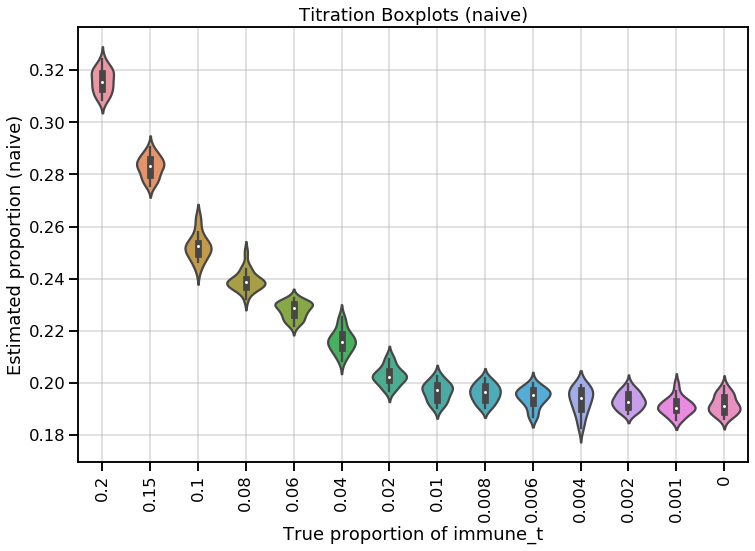

In [21]:
dcnv.boxplot_titration(list_of_deconvolution_dfs=deconvolution_naive,
                      cell_type=TITRATING_CELLTYPE_ATLAS,
                      true_proportions=TITRATION_LIST,
                      deconvolution_method_name='naive'
                      )

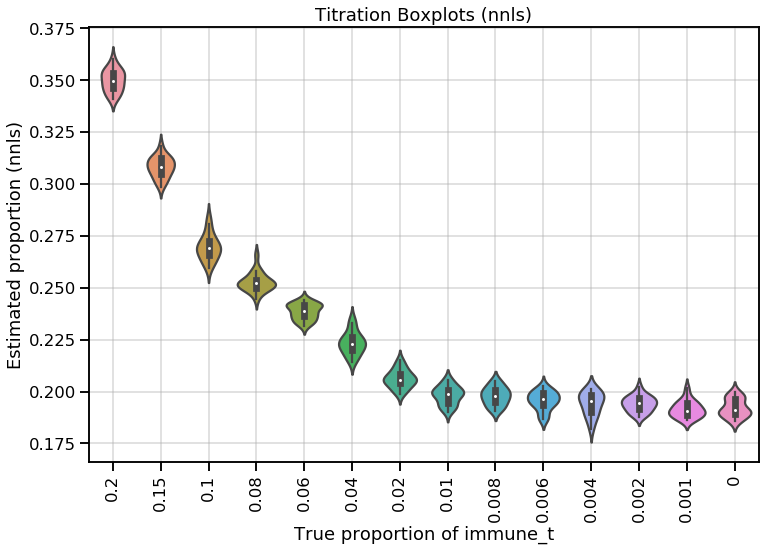

In [22]:
dcnv.boxplot_titration(list_of_deconvolution_dfs=deconvolution_nnls,
                      cell_type=TITRATING_CELLTYPE_ATLAS,
                      true_proportions=TITRATION_LIST,
                      deconvolution_method_name='nnls'
                      )

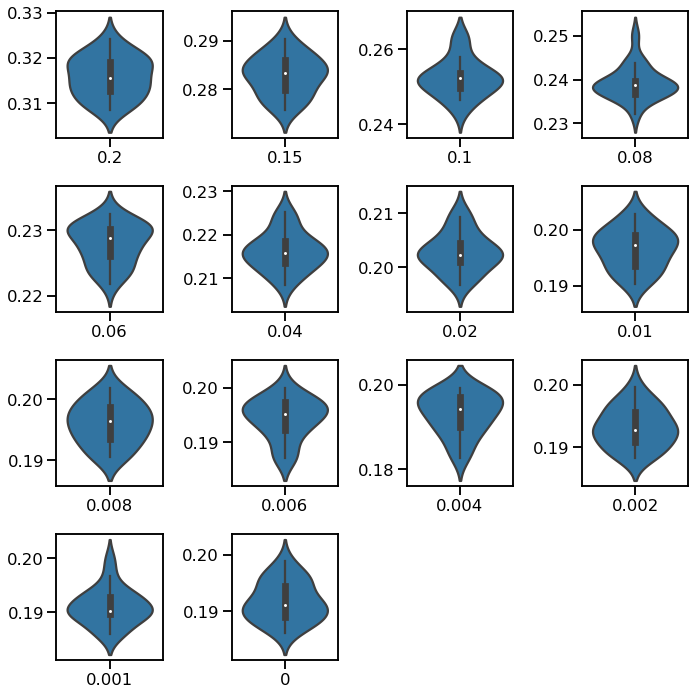

In [23]:

dcnv.boxplot_titration_zoom(list_of_deconvolution_dfs=deconvolution_naive,
                      cell_type=TITRATING_CELLTYPE_ATLAS,
                      true_proportions=TITRATION_LIST,
                      deconvolution_method_name='naive'
                      )

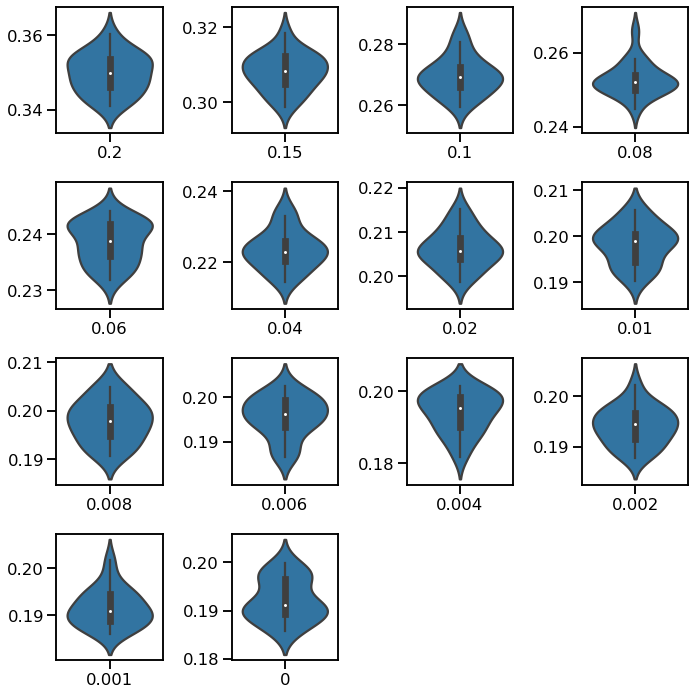

In [24]:

dcnv.boxplot_titration_zoom(list_of_deconvolution_dfs=deconvolution_nnls,
                      cell_type=TITRATING_CELLTYPE_ATLAS,
                      true_proportions=TITRATION_LIST,
                      deconvolution_method_name='nnls'
                      )